# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [1]:
import struct
import numpy as np
import pandas as pd
import random
from pprint import pprint

from guess_range import *

In [2]:
def generate_known_inputs(exps=(-1, 3), nsize=3000):
    low, high = exps[0], (exps[1] + 1)
    subsize = int(nsize / (high - low))
    return pd.DataFrame(
        data=[np.random.uniform(-10.0 ** i, 10.0 ** i, subsize) for i in range(low, high)],
        index=range(low, high))

In [3]:
def guess_number_range_stat(secret_number, guess_range, prescision, known_input_size=3000):
    known_input_set = generate_known_inputs(exps=(-1, 3), nsize=known_input_size)
    results = guess_number_range_multiple_inputs(secret_number, guess_range, prescision, known_input_set)
    # pprint(results)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(prescision)))
    return results[~guess_values.duplicated(keep='first')]

In [4]:
SECRET_VALUE = 'secret value'

guess_range = (-5e0, 5.0e0)
prescision = 1e-7
#
# initalize parameter and generate a random number (secret number)
known_input_size = 5000

## Test single point

In [5]:
secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10) 

In [6]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, prescision, known_input_size)
print(secret_number)
single_results

0.25672341624642425
CPU times: user 33.8 s, sys: 935 ms, total: 34.7 s
Wall time: 34.7 s


,low value,high value,correlation
2,0.256723,0.256723,1.000000
3,4.107575,4.107575,0.984855


In [7]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

2       0.000004
3    1499.999990
dtype: float64
'the secret number = 0.256723'
'the guessed number = 0.256723'
'best correlation = 1.000000'
'error rate = 0.000004%'


## Test multiple points

In [8]:
multiple_results = pd.DataFrame()

In [9]:
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [10]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue    
    results = guess_number_range_stat(idx, guess_range, prescision, known_input_size)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

'===================='
   low value  high value  correlation  secret value
0  -1.261643   -1.261642          1.0     -1.261642
'===================='
    low value  high value  correlation  secret value
 1  -1.093317   -1.093317     0.999948     -1.093317
-1  -4.373267   -4.373267     0.977378     -1.093317
'===================='
    low value  high value  correlation  secret value
 2   0.142161    0.142161     0.998973      0.142161
-1   2.274578    2.274579     0.979780      0.142161
'===================='
   low value  high value  correlation  secret value
2  -0.358748   -0.358748     1.000000     -0.358748
0  -1.434993   -1.434993     0.979779     -0.358748
'===================='
   low value  high value  correlation  secret value
1   1.424887    1.424887      0.99849      1.424887
'===================='
    low value  high value  correlation  secret value
 0   1.132577    1.132577     1.000000      1.132577
-1   4.530309    4.530309     0.979107      1.132577
'====================

'===================='
   low value  high value  correlation  secret value
1   1.319196    1.319196     0.999950      1.319196
2   2.638393    2.638393     0.951008      1.319196
'===================='
    low value  high value  correlation  secret value
 1   0.388424    0.388424     0.999962      0.388424
-1   1.553697    1.553697     0.955267      0.388424
'===================='
    low value  high value  correlation  secret value
-1   2.587425    2.587425     0.936106      0.020214
'===================='
   low value  high value  correlation  secret value
0  -4.173768   -4.173768          1.0     -4.173768
'===================='
    low value  high value  correlation  secret value
-1  -2.140382   -2.140382          1.0     -2.140382
'===================='
    low value  high value  correlation  secret value
 2   0.144813    0.144813     0.998794      0.144813
-1   2.317002    2.317003     0.982126      0.144813
'===================='
   low value  high value  correlation  secret val

### Save data

In [11]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s.csv' % datetime.now().strftime("%Y%m%d_%H%M%S")
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200522_165131.csv'


### Load data

In [12]:
multiple_results_fname = 'multiple_results-20200522_135753.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
multiple_results

,low value,high value,correlation,secret value
0,-2.437902,-2.437902,1.000000,-2.437902
1,0.359504,0.359504,0.999725,0.359504
2,1.438015,1.438015,0.978289,0.359504
3,0.674754,0.674754,0.999921,0.674754
4,-0.660660,-0.660660,1.000000,-0.660660
...,...,...,...,...
152,2.184563,2.184563,1.000000,2.184563
153,4.369126,4.369127,0.957152,2.184563
154,-0.032531,-0.032531,0.999559,-0.032531
155,-0.464241,-0.464241,0.999963,-0.464241


### Hit targets and missed targets

In [13]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 93/100'
'The number of missed values: 7/100'


### Graphs of the first choices

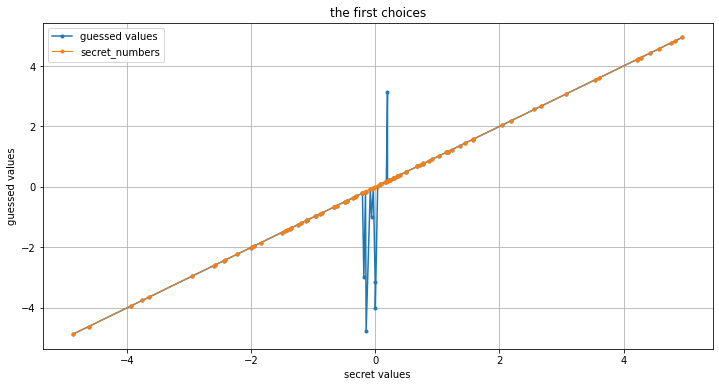

In [14]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

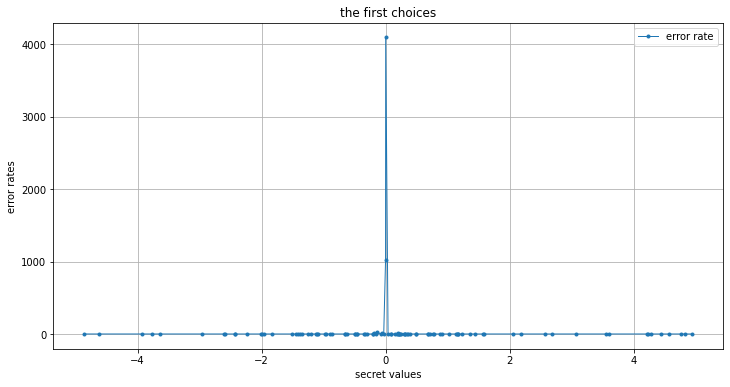

In [15]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [16]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: 34199209670344703'


In [17]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

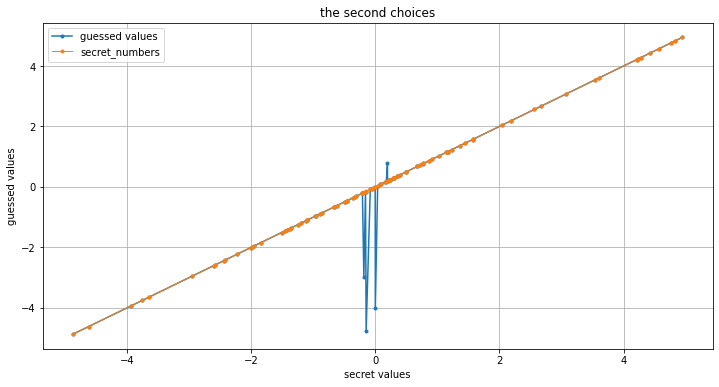

In [18]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

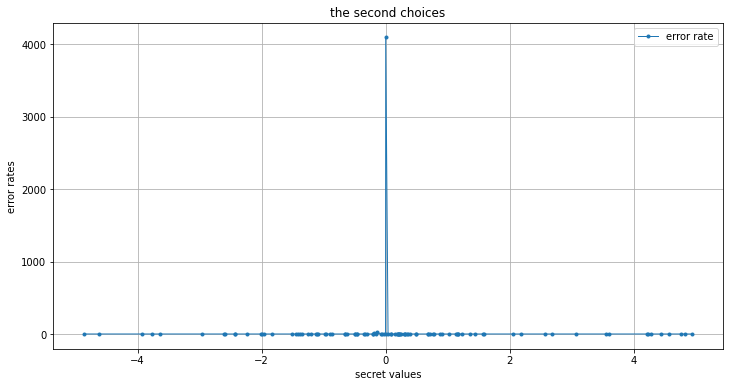

In [19]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [20]:
def batina_guess_number(secret_number, guess_range, prescision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, prescision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    return hw.corr(method='pearson')['actual'].drop('actual').idxmax()

In [21]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)
# we have to define a low precision, otherwise, it takes too long time to run
prescision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, known_input_size)

In [ ]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx] = batina_guess_number(idx, guess_range, prescision, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

### Save data

In [ ]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s.csv' % datetime.now().strftime("%Y%m%d_%H%M%S")
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

### Load data

In [ ]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0)
batinta_results.sort_index(inplace=True)    
batinta_results

### Graphs

In [ ]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

In [ ]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)